In [2]:
#загрузка пакетов и библиотек
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

In [3]:
# Подгружаем доп. модули
from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

In [4]:
from sklearn import tree
from IPython.display import SVG
from IPython.display import display
from graphviz import Source

In [5]:
from IPython.display import HTML
style = "<style>{width:70% !important;height: 70% !important;}</style>"
HTML(style)

In [6]:
sns.set(rc = {'figure.figsize': (9, 6)})

# Анализ времени прохождения курса по статистике на "Stepik"

# Предобработка данных

`events_train.csv` - данные о действиях, которые совершают студенты со стэпами

1. step_id - id стэпа
2. user_id - анонимизированный id юзера
3. timestamp - время наступления события в формате unix date
4. action - событие, возможные значения: 

- _discovered_ - пользователь перешел на стэп
- _viewed_ - просмотр шага,
- _started_attempt_ - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как - - приступить к решению практического шага
- _passed_ - удачное решение практического шага

In [85]:
events_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip', sep = ',')

In [86]:
events_data.head(5)

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


`submissions_train.csv` - данные о времени и статусах сабмитов к практическим заданиям

1. step_id - id стэпа
2. timestamp - время отправки решения в формате unix date
3. submission_status - статус решения
4. user_id - анонимизированный id юзера

In [87]:
submissions_train = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip', sep = ',')

In [88]:
submissions_train.head(5)

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [89]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit = 's')
events_data['date'] = events_data.date.dt.date

In [90]:
submissions_train['date'] = pd.to_datetime(submissions_train.timestamp, unit = 's')
submissions_train['date'] = submissions_train.date.dt.date

[Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Count of unique users'),
 Text(0.5, 1.0, 'Distribution of unique users in time')]

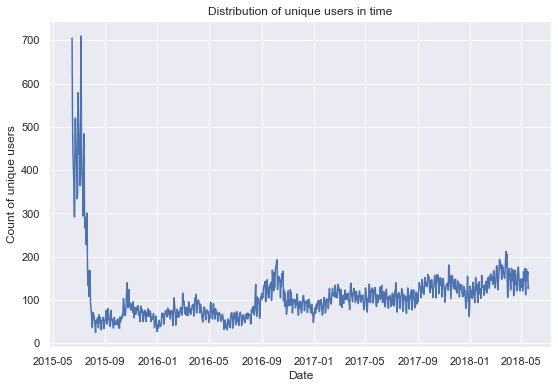

In [91]:
events_data.groupby('date').user_id.nunique().plot().set(xlabel = 'Date', 
                                                         ylabel = 'Count of unique users', 
                                                         title = 'Distribution of unique users in time')
#виден первоначальный хайп курса, в дальнейшем уровень интереса упал, однако заметен на протяжении всего периода после 
#падения тренд на возрастание числа уникальных пользователей

In [92]:
user_events = events_data.pivot_table(
    index = 'user_id', 
    columns = 'action', 
    values = 'step_id', 
    aggfunc = 'count', 
    fill_value = 0
).reset_index().rename_axis('', axis = 1)

[Text(0.5, 0, 'Count of solved tasks'),
 Text(0, 0.5, 'Count of users'),
 Text(0.5, 1.0, 'Distribution of solved tasks by users')]

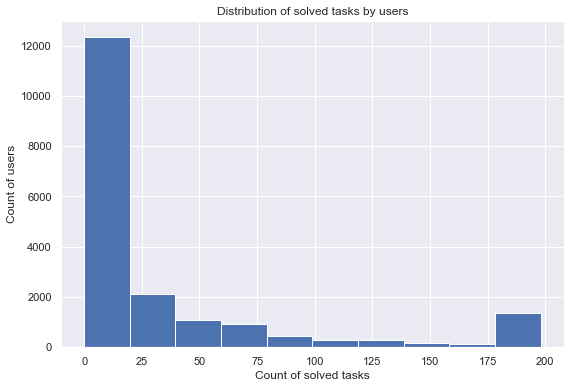

In [93]:
user_events.passed.hist().set(xlabel = 'Count of solved tasks',
                             ylabel = 'Count of users',
                             title = 'Distribution of solved tasks by users')

In [94]:
# 1972 чащихся не решили ни одной задачи
user_events.query('passed == 0').shape[0]

1972

In [95]:
user_submissions = submissions_train.pivot_table(
    index='user_id', 
    columns='submission_status', 
    values='step_id', 
    aggfunc='count', 
    fill_value=0
).reset_index().rename_axis('', axis=1)

In [96]:
# Сколько уникальных дней учились пользователи:
unique_days = events_data.groupby('user_id').date.nunique().to_frame() \
    .rename(columns={'date': 'unique_days'})

In [97]:
# 50% были на курсе один день и больше никогда не заходили.
# 30% учились 5 уникальных дней и более.
unique_days.describe(percentiles=[.51, .6, .61, .66, .67, .7, .71, .73, .74, .75, .76, .78, .79])

,unique_days
count,19234.000000
mean,6.088489
std,12.341683
min,1.000000
50%,1.000000
51%,2.000000
60%,2.000000
61%,3.000000
66%,3.000000
67%,4.000000


# Каких пользователей считаем прошедшими курс?

In [98]:
# Чтобы получить сертификат, надо решить 170 задач.
# Получил сертификат - значит прошел курс.
passed_score = 170

In [99]:
# Посмотрим количество пройденных практических шагов:
users = user_events[['user_id', 'passed']]

In [100]:
# Добавим флаг, прошел ли пользователь курс:
users['passed_course'] = users.passed >= passed_score
users.passed_course = users.passed_course.map(int)

In [101]:
# Узнаем время первого и последнего захода на курс:
first_visits = events_data.groupby('user_id').timestamp.min().to_frame().rename(columns={'timestamp': 'first_visit'})
last_visits = events_data.groupby('user_id').timestamp.max().to_frame().rename(columns={'timestamp': 'last_visit'})

In [102]:
# Добавим первый и последний заходы на курс:
users = users.merge(first_visits, on='user_id')
users = users.merge(last_visits, on='user_id')

0    17801
1     1433
Name: passed_course, dtype: int64

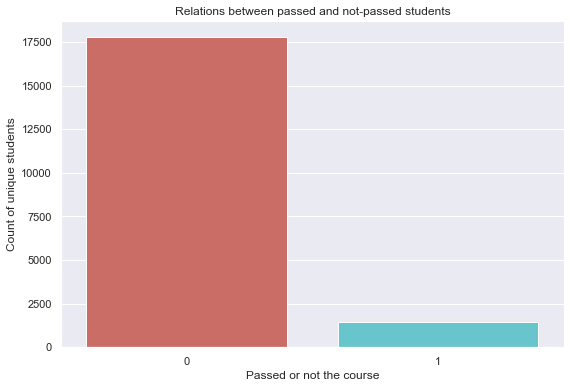

In [103]:
# Количественное соотношение прошедших и непрошедших курс:
sns.countplot(x = 'passed_course', data = users, palette = 'hls').set(xlabel = 'Passed or not the course',
                                                                     ylabel = 'Count of unique students',
                                                                     title = 'Relations between passed and not-passed students')
users.passed_course.value_counts()

# Каких пользователей считаем ушедшими с курса?

Надо понять, пользователи без сертификата еще учатся или уже бросили курс?

Попробуем 2 подхода:

1. Изучим длительность обучения пользователей, получивших сертификат. Возьмем максимальное количество дней или какой-нибудь 99 персентиль в качестве "порога длительности обучения". Если пользователь без сертификата учится дольше, чем порог - считаем что он бросил курс.
2. Изучим перерывы в обучении у пользователей, получивших сертификат. Возьмем максимальный перерыв или какой-нибудь 99 персентиль в качестве "порога длительности отсутствия". Если от последнего событитя пользователя до сегодняшнего дня прошло больше времени, чем порог - считаем что он бросил курс.

### 1 подход: Длительность обучения пользователей с сертификатом

In [104]:
# Отберем события пользователей, прошедших курс:
events_of_passed_course_users = events_data[events_data['user_id'].isin(users[users['passed_course'] == True].user_id)]

In [105]:
# Узнаем время правильного решения 170-й задачи. Это и будет время окончания курса.
# Для этого соберем датафрейм из первых 170-ти событий успешного решения практического шага:
tmp = events_of_passed_course_users.query('action == "passed"') \
    .sort_values(['user_id', 'timestamp']) \
    .groupby('user_id') \
    .head(passed_score)

In [106]:
# Максимальный таймстемп каждого пользователя - это время получения сертификата:
obtaining_certs = tmp.groupby('user_id').timestamp.max().to_frame() \
    .rename(columns={'timestamp': 'obtaining_cert'})

In [107]:
# Создадим датафрейм, поместим туда прошедших курс пользователей:
passed_course_users = users.query('passed_course == True')

# Добавим время получения сертификата:
passed_course_users = passed_course_users.merge(obtaining_certs, on='user_id')

In [108]:
passed_course_users['days_spent_on_obtaining_cert'] = \
    np.ceil(
        (passed_course_users['obtaining_cert'] - passed_course_users['first_visit']) / (24 * 60 * 60)
    ).map(int)

<AxesSubplot:>

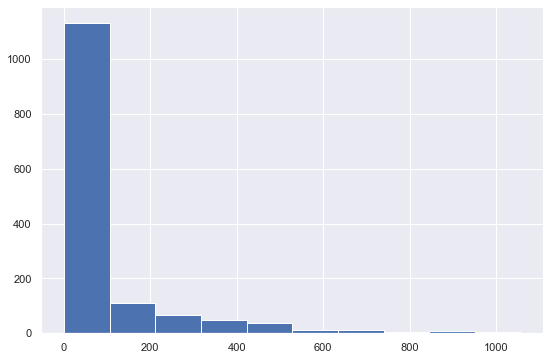

In [109]:
# Ось x - количество дней, ось y - количество учеников:
passed_course_users['days_spent_on_obtaining_cert'].hist()

<AxesSubplot:>

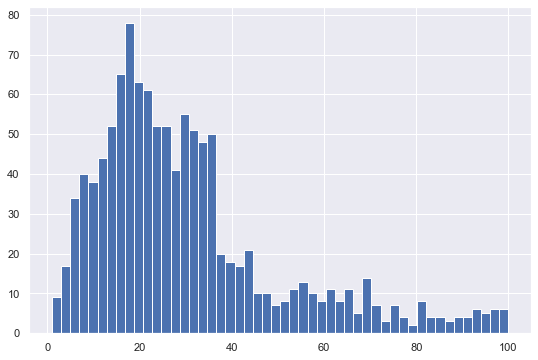

In [110]:
# Посмотрим подробнее первую сотню:
passed_course_users.query('days_spent_on_obtaining_cert <= 100').days_spent_on_obtaining_cert.hist(bins=50)

In [111]:
# Наблюдаем очень быстрое прохождение курса у 8-ми пользователей.
# Если не переводить значение в целые дни, то там будет от 30 до 45 мин у первых 8-ми пользователей.
# Может команда курса тестировала?
passed_course_users.sort_values('days_spent_on_obtaining_cert').head(10)

,user_id,passed,passed_course,first_visit,last_visit,obtaining_cert,days_spent_on_obtaining_cert
519,9104,195,1,1522098760,1522183769,1522111098,1
957,17191,190,1,1455013305,1458322391,1455024723,1
625,11061,196,1,1521015150,1523169005,1521017255,1
1138,21010,181,1,1482449434,1482475233,1482475149,1
564,9956,184,1,1463316278,1463380111,1463318306,1
1077,19805,198,1,1509741291,1512210943,1509744324,1
1220,22833,194,1,1464164406,1517842929,1464166049,1
651,11574,185,1,1478609068,1478629364,1478629003,1
248,4106,193,1,1458310371,1458484260,1458473308,2
1180,22059,197,1,1514928356,1515238451,1515182835,3


In [112]:
passed_course_users['days_spent_on_obtaining_cert'].describe(percentiles=[.9, .95, .99])

# Сколько дней обучения брать в качестве порога?

# Например, считаем, что пользователь бросил курс, если он не получил сертификат и уже учится более 434 дней (95 персентиль).

# Пользователи, которые не имеют сертификат и учатся меньше 434 дней, будут в неопределенном статусе.

# Посмотрим, сколько таких пользователей будет при взятии различных порогов.

count    1433.000000
mean       92.387299
std       152.200695
min         1.000000
50%        31.000000
90%       283.800000
95%       434.000000
99%       747.440000
max      1056.000000
Name: days_spent_on_obtaining_cert, dtype: float64

In [113]:
# Пользователи без сертификатов:
not_passed_course_users = users.query('passed_course == False')

In [114]:
# Найдем среди участников без сертификата пользователей, которые учатся более 747 дней (99 квантиль).
training_length_threshold = 747 * 24 * 60 * 60
now = events_data.timestamp.max()

not_passed_course_users.query('first_visit + @training_length_threshold < @now').user_id
# следующих товарищей считаем бросившими курс

2            3
8           14
11          18
12          20
17          28
         ...  
19219    26778
19223    26783
19225    26786
19228    26789
19229    26790
Name: user_id, Length: 6384, dtype: int64

In [115]:
lost_1_way = users[users.user_id.isin(not_passed_course_users.query('first_visit + @training_length_threshold < @now').user_id)]
# потерявшиеся после 1 подходу

### 2 подход: Перерывы в обучении у получивших сертификат

In [116]:
# Добавим время получения сертификата к событиям пользователей получивших сертификат:
events_of_passed_course_users = events_of_passed_course_users \
    .merge(passed_course_users[['user_id', 'obtaining_cert']], on='user_id')

In [117]:
max_breaks_of_passed_course_users  = events_of_passed_course_users \
    .query('timestamp <= obtaining_cert')[['user_id', 'timestamp']] \
    .groupby('user_id')['timestamp'] \
    .apply(list) \
    .apply(np.diff) \
    .apply(np.max) \
    .to_frame().rename(columns={'timestamp': 'max_break'})

In [118]:
# Переведем секунды в дни:
max_breaks_of_passed_course_users['max_break'] = \
    np.ceil(
        max_breaks_of_passed_course_users['max_break'] / (24 * 60 * 60)
    ).map(int)

In [119]:
# Добавим максимальный перерыв между событиями к пользователям, получившим сетрификат:
passed_course_users = passed_course_users.merge(max_breaks_of_passed_course_users, on='user_id')
passed_course_users

,user_id,passed,passed_course,first_visit,last_visit,obtaining_cert,days_spent_on_obtaining_cert,max_break
0,16,196,1,1435674765,1513162585,1513094298,897,708
1,22,198,1,1498561010,1507142631,1500036463,18,4
2,30,198,1,1467307716,1510574287,1509095682,484,146
3,34,195,1,1493156230,1525626844,1504794582,135,58
4,39,198,1,1456943480,1502712399,1459445025,29,4
...,...,...,...,...,...,...,...,...
1428,26740,188,1,1444388456,1463224362,1456347416,139,95
1429,26763,193,1,1434350514,1436216740,1436205266,22,5
1430,26777,191,1,1434374498,1436605200,1436462092,25,7
1431,26779,196,1,1473155734,1520157100,1476952592,44,8


[Text(0.5, 0, 'Max days of a break'),
 Text(0, 0.5, 'Count of users'),
 Text(0.5, 1.0, "Distribution of max days of users' break")]

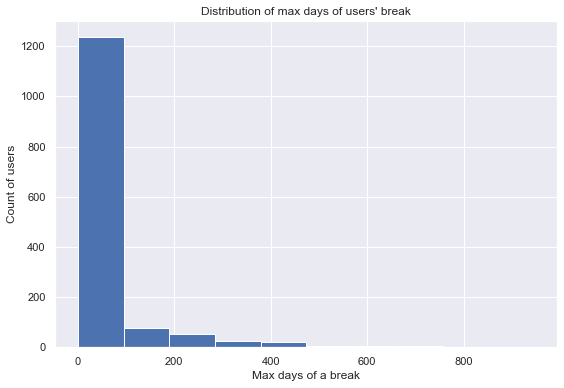

In [120]:
passed_course_users['max_break'].hist() \
    .set(xlabel = 'Max days of a break',
        ylabel = 'Count of users',
        title = 'Distribution of max days of users' + "'" + ' break')

In [121]:
passed_course_users['max_break'].describe(percentiles=[.9, .95, .99])

# Какой максимальный перерыв брать в качестве порога?
# Посмотрим, сколько пользователей мы "потеряем" при взятии различных порогов.

count    1433.000000
mean       48.413119
std       107.147067
min         1.000000
50%         8.000000
90%       144.000000
95%       274.600000
99%       536.680000
max       947.000000
Name: max_break, dtype: float64

In [122]:
# Отберем события пользователей без сертификата:
events_of_not_passed_course_users = events_data[events_data['user_id'].isin(users.query('passed_course == False').user_id)]

In [123]:
# Получим максимальный перерыв между событиями для каждого пользователя без сертификата.
# Время от последнего события пользователя до "сегодняшнего" момента тоже надо учесть.
max_breaks_of_not_passed_course_users = events_of_not_passed_course_users[['user_id', 'timestamp']] \
    .groupby('user_id')['timestamp'] \
    .apply(list) \
    .apply(lambda x: x + [now]) \
    .apply(np.diff) \
    .apply(np.max) \
    .to_frame().rename(columns={'timestamp': 'max_break'})

In [124]:
# Переведем секунды в дни:
max_breaks_of_not_passed_course_users['max_break'] = \
    np.ceil(
        max_breaks_of_not_passed_course_users['max_break'] / (24 * 60 * 60)
    ).map(int)

In [125]:
# Добавим максимальный перерыв к пользователям без сертификата:
not_passed_course_users = not_passed_course_users.merge(max_breaks_of_not_passed_course_users, on='user_id')

In [126]:
breaks_in_training_threshold = 536

not_passed_course_users.query('max_break > @breaks_in_training_threshold')
# следующих товарищей считаем бросившими курс

,user_id,passed,passed_course,first_visit,last_visit,max_break
0,1,0,0,1472827464,1472827464,625
2,3,87,0,1434358476,1444581588,952
8,14,3,0,1436366155,1436368676,1047
9,17,5,0,1465762612,1465765342,707
10,18,2,0,1438541140,1438541223,1022
...,...,...,...,...,...,...
17787,26776,16,0,1445007199,1445010128,947
17788,26778,9,0,1436470218,1474007319,611
17790,26783,10,0,1434542952,1434543274,1068
17795,26789,2,0,1447263411,1447263419,921


In [127]:
lost_2_way = users[users.user_id.isin(not_passed_course_users.query('max_break > @breaks_in_training_threshold').user_id)]
# потерявшиеся после 2 подхода

In [128]:
print(f'Число потерявшихся по 1 подходу равно {lost_1_way.shape[0]}')
print(f'Число потерявшихся по 2 подходу равно {lost_2_way.shape[0]}')

Число потерявшихся по 1 подходу равно 6384
Число потерявшихся по 2 подходу равно 8328


0    9473
1    1433
Name: passed_course, dtype: int64

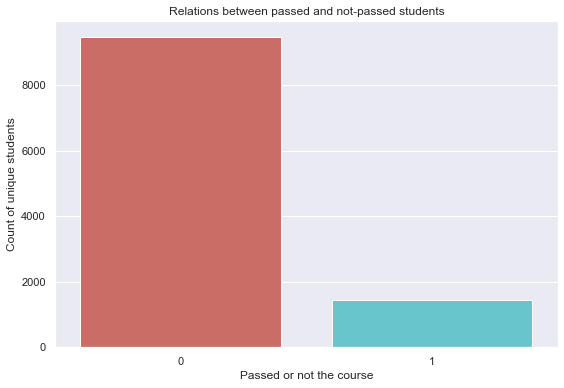

In [129]:
sns.countplot(x = 'passed_course', data = users[users.user_id.isin(lost_2_way.user_id) == False], palette = 'hls') \
    .set(xlabel = 'Passed or not the course',
         ylabel = 'Count of unique students',
         title = 'Relations between passed and not-passed students')
users[users.user_id.isin(lost_2_way.user_id) == False].passed_course.value_counts()

In [130]:
# Я пойду по 2 способу и приму эвристику, что пользователи, имеющие перерыв более 536 дней (99% перцентиль времени перерыва
# пользователей, прошедших курс), являются покинувшими курс
users = users.merge(
    pd.concat([max_breaks_of_passed_course_users, max_breaks_of_not_passed_course_users]),
    on='user_id'
)

users['is_gone'] = 0
users.loc[(users['passed_course'] == 0) & (users['max_break'] > breaks_in_training_threshold), 'is_gone'] = 1
users

,user_id,passed,passed_course,first_visit,last_visit,max_break,is_gone
0,1,0,0,1472827464,1472827464,625,1
1,2,9,0,1514383364,1519226966,88,0
2,3,87,0,1434358476,1444581588,952,1
3,5,11,0,1466156809,1499859939,391,0
4,7,1,0,1521634660,1521634660,60,0
...,...,...,...,...,...,...,...
19229,26790,8,0,1451484016,1517495987,751,1
19230,26793,0,0,1510225031,1510225034,192,0
19231,26794,69,0,1495287049,1512035039,171,0
19232,26797,10,0,1508425316,1509995096,195,0


In [131]:
# Небольшая ремарка в честь задания по данному проекту
# Был выдвинут интересный вопрос, найти номер стэпа, после которого большее число пользователей покинуло курс - проблемный урок
# Я предлагаю следующее решение: попросту отфильтроваться по неправельным стэпам и найти id стэпа, где было больше всего ошибок

# submissions_train.query("submission_status == 'wrong'").groupby(['user_id', 'step_id']).agg({'submission_status': 'count'}) \
#     .reset_index('step_id').value_counts('step_id')

In [132]:
# Удалим пользователей в "неопределенном" статусе, которые и не прошли курс, и не успели его бросить:
users = users[(users['is_gone'] == True) | (users['passed_course'] == True)].drop('passed_course', axis=1)
users

,user_id,passed,first_visit,last_visit,max_break,is_gone
0,1,0,1472827464,1472827464,625,1
2,3,87,1434358476,1444581588,952,1
8,14,3,1436366155,1436368676,1047,1
9,16,196,1435674765,1513162585,708,0
10,17,5,1465762612,1465765342,707,1
...,...,...,...,...,...,...
19220,26779,196,1473155734,1520157100,8,0
19221,26781,198,1487693786,1507540704,20,0
19223,26783,10,1434542952,1434543274,1068,1
19228,26789,2,1447263411,1447263419,921,1


In [133]:
# Нужно предсказать, что пользователь покинет курс как можно раньше, пока он еще здесь.
# Правда ли, что по поведению пользователя на курсе за первую неделю (или несколько дней)
# можно предсказать закончит он курс или нет?

# Попробуем порог в 3 дня:
learning_time_threshold = 3 * 24 * 60 * 60

# Для каждого пользователя отберем события, которые с ним происходили в течение первых 3 дней:
events_train = events_data[events_data['user_id'].isin(users['user_id'])]
events_train = events_train.merge(first_visits, on='user_id')
events_train = events_train.query("timestamp - first_visit < @learning_time_threshold")
events_train

,step_id,timestamp,action,user_id,date,first_visit
0,32815,1434341931,passed,12494,2015-06-15,1434341931
1,32815,1434341931,discovered,12494,2015-06-15,1434341931
2,32815,1434341931,viewed,12494,2015-06-15,1434341931
3,32811,1434341937,viewed,12494,2015-06-15,1434341931
4,32811,1434341937,passed,12494,2015-06-15,1434341931
...,...,...,...,...,...,...
2191678,34004,1525214077,viewed,5573,2018-05-01,1524955364
2191679,34004,1525214077,discovered,5573,2018-05-01,1524955364
2191680,33896,1525214489,passed,5573,2018-05-01,1524955364
2191681,33896,1525214489,viewed,5573,2018-05-01,1524955364


In [134]:
# Для каждого пользователя отберем сабмиты, которые они отправляли в течение первых 3 дней:
submissions = submissions_train[submissions_train['user_id'].isin(users['user_id'])]
submissions = submissions.merge(first_visits, on='user_id')
submissions = submissions.query('timestamp - first_visit <= @learning_time_threshold')
submissions

,step_id,timestamp,submission_status,user_id,date,first_visit
0,31971,1434349275,correct,15853,2015-06-15,1434345977
1,31972,1434348300,correct,15853,2015-06-15,1434345977
4,31976,1434348123,wrong,15853,2015-06-15,1434345977
5,31976,1434348188,correct,15853,2015-06-15,1434345977
7,31977,1434347371,correct,15853,2015-06-15,1434345977
...,...,...,...,...,...,...
330465,120745,1476419925,wrong,10312,2016-10-14,1476417044
330466,120745,1476419953,correct,10312,2016-10-14,1476417044
330467,120745,1476767714,correct,21817,2016-10-18,1476767576
330470,120745,1478563508,correct,26766,2016-11-08,1478561209


In [135]:
# Соберем X:
X = users[['user_id','is_gone']]

# Посчитаем количество уникальных дней, в которые пользователь решал задачи:
days_of_training = submissions_train.groupby('user_id').date.nunique().to_frame() \
    .rename(columns={'date': 'days_of_training'})

# Посчитаем количество задач, которые пользователь попробовал решить:
steps_tried = submissions_train.groupby('user_id').step_id.nunique().to_frame() \
    .rename(columns={'step_id': 'tasks_tried'})

# Посчитаем количество правильных и неправильных ответов:
submission_statuses = submissions_train.pivot_table(
    index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0
)

# Посчитаем количество просмотренных шагов:
viewed = events_train.pivot_table(
    index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0
).reset_index().rename_axis('', axis=1)[['user_id', 'viewed']]

X = X.merge(days_of_training, on='user_id', how='outer')
X = X.merge(steps_tried, on='user_id', how='outer')
X = X.merge(submission_statuses, on='user_id', how='outer')
X = X.merge(viewed, on='user_id')
X

,user_id,is_gone,days_of_training,tasks_tried,correct,wrong,viewed
0,1,1.0,NaN,NaN,NaN,NaN,1
1,3,1.0,5.0,29.0,29.0,23.0,20
2,14,1.0,1.0,1.0,0.0,1.0,9
3,16,0.0,13.0,76.0,77.0,106.0,132
4,17,1.0,1.0,1.0,0.0,2.0,13
...,...,...,...,...,...,...,...
9756,26779,0.0,19.0,76.0,76.0,41.0,44
9757,26781,0.0,20.0,76.0,92.0,75.0,6
9758,26783,1.0,1.0,2.0,2.0,0.0,20
9759,26789,1.0,NaN,NaN,NaN,NaN,2


In [136]:
# Рассчитаем процент правильных ответов:
X['correct_ratio'] = X['correct'] / (X['correct'] + X['wrong'])

# Заполним ячейки со значением "Nan" нулями:
X = X.fillna(0)

# Конвертируем значения в целые числа:
for col in ['days_of_training', 'tasks_tried', 'correct', 'wrong']:
    X[col] = X[col].map(int)

# Сделаем индекс по ID пользователя:
X = X.rename_axis('', axis=1).set_index('user_id')
X

,is_gone,days_of_training,tasks_tried,correct,wrong,viewed,correct_ratio
user_id,,,,,,,
1,1.0,0,0,0,0,1,0.000000
3,1.0,5,29,29,23,20,0.557692
14,1.0,1,1,0,1,9,0.000000
16,0.0,13,76,77,106,132,0.420765
17,1.0,1,1,0,2,13,0.000000
...,...,...,...,...,...,...,...
26779,0.0,19,76,76,41,44,0.649573
26781,0.0,20,76,92,75,6,0.550898
26783,1.0,1,2,2,0,20,1.000000


In [137]:
# Соберем y:
y = X['is_gone']
X = X.drop(['is_gone'], axis=1)

x_train, x_test, y_train, y_test= train_test_split(X, y, test_size = .33, random_state = 0)

### Применим алгоритм решающего дерева, отобрав наилучшую модель "руками"

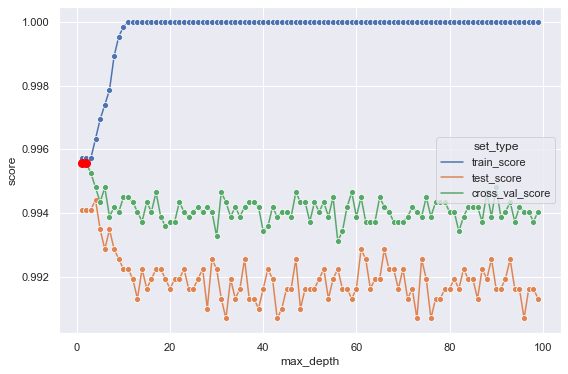

In [138]:
# Пишем цикл нахождения оценок (accuracy) относительно изменения глубины дерева c учетом усредненного показателя точности на
# кроссвалидации с тюнингом гиперпараметра глубины дерева
max_depth_value = range(1, 100)
scores_data = pd.DataFrame()

for max_depth in max_depth_value:
    clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = max_depth)
    clf.fit(x_train, y_train)
    train_score = clf.score(x_train, y_train)
    test_score = clf.score(x_test, y_test)
    mean_cross_val_score = cross_val_score(clf, x_train, y_train, cv = 10).mean()
    
    temp_data = pd.DataFrame({'max_depth': [max_depth], 
                              'train_score': [train_score], 
                              'test_score': [test_score],
                              'cross_val_score': [mean_cross_val_score]})
    scores_data = scores_data.append(temp_data)

# Визуализируем результаты, обозначив значение максимального скора при кросс-валидаци
scores_data_melt = pd.melt(scores_data, id_vars = ['max_depth'], value_vars = ['train_score', 'test_score', 'cross_val_score'],
                          var_name = 'set_type', value_name = 'score')

sns.lineplot(x = 'max_depth', y = 'score', hue = 'set_type', data = scores_data_melt, marker = 'o')
plt.plot(scores_data.query("cross_val_score == cross_val_score.max()").max_depth,
         scores_data.query("cross_val_score == cross_val_score.max()").cross_val_score, 
         marker = "o", ms = 8, color = 'red')
# Получим, что наибольший скор на кросс-валидации достигается при глубине дерева, равного 2

In [139]:
best_clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 2)
best_clf.fit(x_train, y_train)
best_clf.score(x_test, y_test)
# Получили точность в 99.4% на наилучшей модели - получилось довольно успешно

0.9941030415890751

In [140]:
import os
os.environ["PATH"] += os.pathsep + 'C:\\Users\\123\\anaconda3\\pkgs\\graphviz-2.38-hfd603c8_2\\Library\\bin\\graphviz'

def draw_graphviz(graph):
    import re
    import ipywidgets as widgets
    from IPython.display import SVG, HTML
    from graphviz import Source
    
    graph = Source(graph)
    image = graph.pipe(format="svg")
    svg = SVG(image)
    svg_data = svg.data
    svg_data = re.sub(
        r'<svg xmlns=\"http://www\.w3\.org/2000/svg\" xmlns:xlink=\"http://www\.w3\.org/1999/xlink\" width=\"\d+pt\" height=\"\d+pt\"',
        '<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" width="100%" height="100%"',
        svg_data,
    )
    
    @widgets.interact(scale=widgets.IntSlider(min=30, max=500, step=1, value=100, description="Scale (%):", continuous_update=False))
    def _draw_svg(scale):
        return HTML('<div style="width: {width}%;">{svg}</div>'.format(width=scale, svg=svg_data))
    return _draw_svg

graph = tree.export_graphviz(best_clf, out_file = None,
                                   feature_names = list(X),
                                   class_names = ['Gone', 'Passed'],
                                   filled = True)
draw_graphviz(graph)
# Изображаем решающее дерево, полученно после обучения модели на исходных X и Y

interactive(children=(IntSlider(value=100, continuous_update=False, description='Scale (%):', max=500, min=30)…

<function __main__.draw_graphviz.<locals>._draw_svg(scale)>

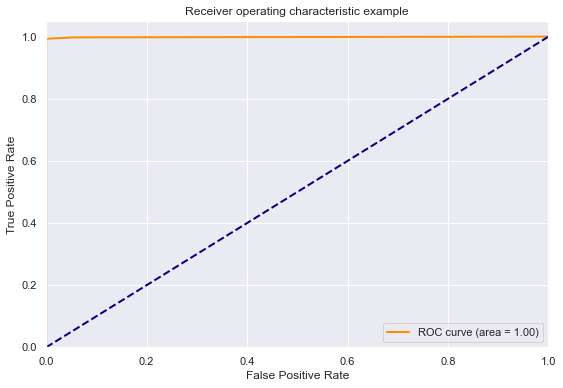

In [141]:
y_predicted_prob = best_clf.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', 
         lw = 2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
# Оценка ROC-кривой также показывает, что у нас нет проблемы с неверно классифицированными 

# Применение метода решающего дерева на примере датасета "Titanic"

In [142]:
# Ставлю директорую в PATH, чтобы программа могла обращаться к части dot модуля graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:\\Users\\123\\anaconda3\\pkgs\\graphviz-2.38-hfd603c8_2\\Library\\bin\\graphviz'

In [143]:
# Подгружаем данные с API Kaggle
api = KaggleApi()
api.authenticate()

In [144]:
api.competition_download_file('titanic',
                             'train.csv')

train.csv: Skipping, found more recently modified local copy (use --force to force download)


In [145]:
titanic_data = pd.read_csv('/Users/123/train.csv')
titanic_data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [146]:
titanic_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [147]:
X = titanic_data.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis = 1)
Y = titanic_data['Survived']

X.loc[X[(X.Age.isna() == True) & (X.Sex == 'male')].index,'Age'] = \
X.loc[X[(X.Age.isna() == True) & (X.Sex == 'male')].index,'Age'].fillna(
    X.loc[X[(X.Age.isna() == False) & (X.Sex == 'male')].index,'Age'].median())

X.loc[X[(X.Age.isna() == True) & (X.Sex == 'female')].index,'Age'] = \
X.loc[X[(X.Age.isna() == True) & (X.Sex == 'female')].index,'Age'].fillna(
    X.loc[X[(X.Age.isna() == False) & (X.Sex == 'female')].index,'Age'].median())

X = pd.get_dummies(X)
# Выбираем фитчи и отклики, которые хотим классифицировать. Также заполняем NA значения медианой для женщин и мужчин

In [148]:
clf = tree.DecisionTreeClassifier(criterion = 'entropy')
clf.fit(X, Y)

DecisionTreeClassifier(criterion='entropy')

In [149]:
def draw_graphviz(graph):
    import re
    import ipywidgets as widgets
    from IPython.display import SVG, HTML
    from graphviz import Source
    
    graph = Source(graph)
    image = graph.pipe(format="svg")
    svg = SVG(image)
    svg_data = svg.data
    svg_data = re.sub(
        r'<svg xmlns=\"http://www\.w3\.org/2000/svg\" xmlns:xlink=\"http://www\.w3\.org/1999/xlink\" width=\"\d+pt\" height=\"\d+pt\"',
        '<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" width="100%" height="100%"',
        svg_data,
    )
    
    @widgets.interact(scale=widgets.IntSlider(min=30, max=500, step=1, value=100, description="Scale (%):", continuous_update=False))
    def _draw_svg(scale):
        return HTML('<div style="width: {width}%;">{svg}</div>'.format(width=scale, svg=svg_data))
    return _draw_svg

graph = tree.export_graphviz(clf, out_file = None,
                                   feature_names = list(X),
                                   class_names = ['Died', 'Survived'],
                                   filled = True)
draw_graphviz(graph)
# Изображаем решающее дерево, полученно после обучения модели на исходных X и Y. Вляпились в переобучение

interactive(children=(IntSlider(value=100, continuous_update=False, description='Scale (%):', max=500, min=30)…

<function __main__.draw_graphviz.<locals>._draw_svg(scale)>

In [150]:
x_train, x_test, y_train, y_test= train_test_split(X, Y, test_size = .33, random_state = 42)

In [151]:
max_depth_value = range(1, 100)
scores_data = pd.DataFrame()

for max_depth in max_depth_value:
    clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = max_depth)
    clf.fit(x_train, y_train)
    train_score = clf.score(x_train, y_train)
    test_score = clf.score(x_test, y_test)
    
    temp_data = pd.DataFrame({'max_depth': [max_depth], 
                              'train_score': [train_score], 
                              'test_score': [test_score]})
    scores_data = scores_data.append(temp_data)
# Пишем цикл нахождения оценок (accuracy) относительно изменения глубины дерева

<AxesSubplot:xlabel='max_depth', ylabel='score'>

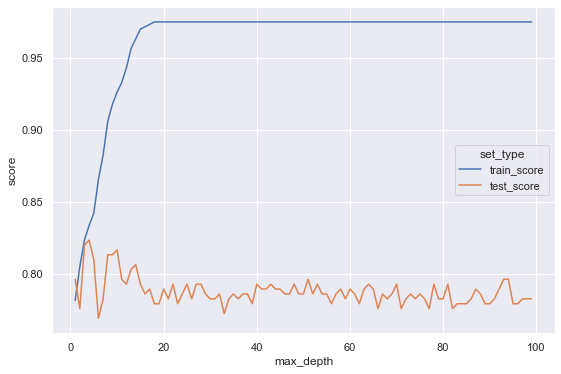

In [152]:
scores_data_melt = pd.melt(scores_data, id_vars = ['max_depth'], value_vars = ['train_score', 'test_score'],
                          var_name = 'set_type', value_name = 'score')

sns.lineplot(x = 'max_depth', y = 'score', hue = 'set_type', data = scores_data_melt)
# После 17 глубины train_score практически не растет, а вот test_score заметно снижается. К тому же опять вляпались в 
# переобучение - обучались на одном и том же датасете. Нужна кроссвалидация

In [153]:
max_depth_value = range(1, 100)
scores_data = pd.DataFrame()

for max_depth in max_depth_value:
    clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = max_depth)
    clf.fit(x_train, y_train)
    train_score = clf.score(x_train, y_train)
    test_score = clf.score(x_test, y_test)
    mean_cross_val_score = cross_val_score(clf, x_train, y_train, cv = 10).mean()
    
    temp_data = pd.DataFrame({'max_depth': [max_depth], 
                              'train_score': [train_score], 
                              'test_score': [test_score],
                              'cross_val_score': [mean_cross_val_score]})
    scores_data = scores_data.append(temp_data)
# Пишем цикл нахождения оценок (accuracy) относительно изменения глубины дерева c учетом усредненного показателя точности на
# кроссвалидации

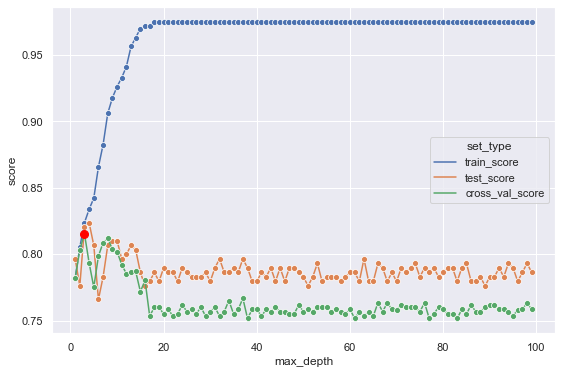

In [154]:
scores_data_melt = pd.melt(scores_data, id_vars = ['max_depth'], value_vars = ['train_score', 'test_score', 'cross_val_score'],
                          var_name = 'set_type', value_name = 'score')

sns.lineplot(x = 'max_depth', y = 'score', hue = 'set_type', data = scores_data_melt, marker = 'o')
plt.plot(scores_data.query("cross_val_score == cross_val_score.max()").max_depth,
         scores_data.query("cross_val_score == cross_val_score.max()").cross_val_score, 
         marker = "o", ms = 8, color = 'red')
# Оптимальной глубиной дерево при кроссвалидации на 10 фолдах является 3
# Переобучим модель с глубиной 3 и посчитаем точность accuracy_score на тестовых данных

In [155]:
best_clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 3)
best_clf.fit(x_train, y_train)
best_clf.score(x_test, y_test)
# Получили точность в 82% на наилучшей модели

0.8203389830508474

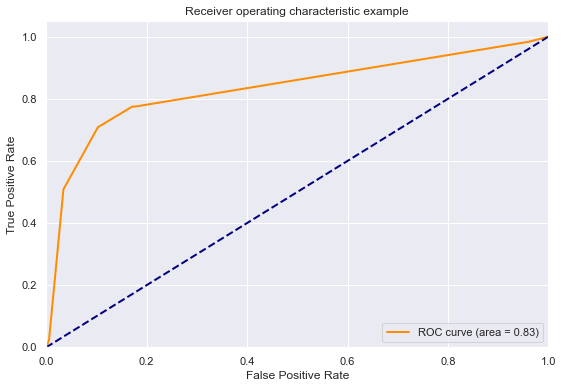

In [156]:
y_predicted_prob = best_clf.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', 
         lw = 2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Kaggle Mushroom competition

In [10]:
from sklearn.ensemble import RandomForestClassifier

In [7]:
data = pd.read_csv('./Downloads/training_mush.csv')
data.head(5)

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,class
0,2,0,3,1,5,1,0,0,9,1,...,3,7,0,2,1,4,3,5,0,0
1,2,0,4,0,5,1,0,1,10,0,...,7,4,0,2,1,0,7,4,0,1
2,2,0,3,0,2,1,0,0,7,0,...,0,4,0,2,1,2,1,5,1,1
3,0,0,3,0,5,1,1,0,2,0,...,7,7,0,2,2,4,7,3,1,0
4,2,3,3,1,5,1,0,0,10,1,...,3,6,0,2,1,4,2,5,0,0


In [25]:
X_train = data.loc[:, data.columns != 'class']
y_train = data.loc[:, 'class']

params = {'n_estimators': range(10, 51, 10),
         'max_depth': range(1, 13, 2),
         'min_samples_leaf': range(1, 7),
         'min_samples_split': range(2, 10, 2)
         }
rf = RandomForestClassifier(random_state = 0)
clf = GridSearchCV(rf, params, cv = 3, n_jobs = -1)
clf.fit(X_train, y_train)
clf.best_params_

{'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 10}

<AxesSubplot:>

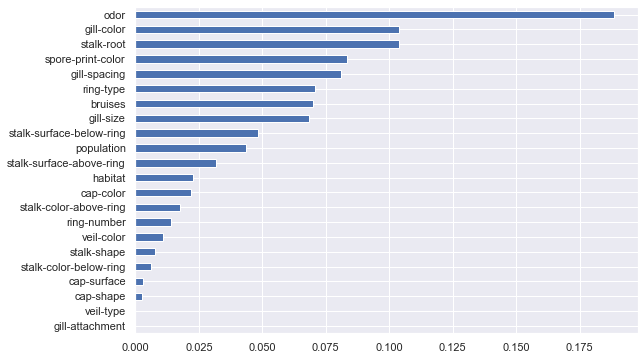

In [45]:
ft_imp = pd.Series(clf.best_estimator_.feature_importances_, X_train.columns)
ft_imp.sort_values(ascending = True).plot(kind = 'barh')

In [47]:
X_test = pd.read_csv('./Downloads/testing_mush.csv')
best_model = clf.best_estimator_
predictions = best_model.predict(X_test)
predictions.sum()

976

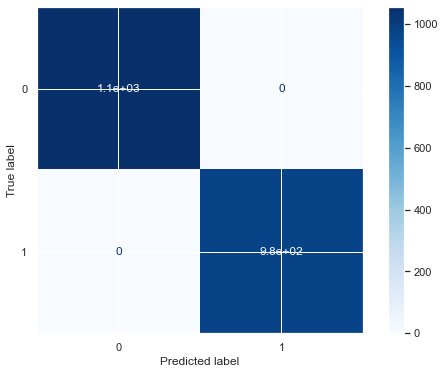

In [53]:
import zipfile
from sklearn.metrics import plot_confusion_matrix

z = zipfile.ZipFile('./Downloads/testing_y_mush.csv.zip', 'r')
txtfile = z.extract('testing_y_mush.csv',pwd = "Cool!Move_forward!".encode('cp850', 'replace'))

y_true = pd.read_csv(txtfile)
plot_confusion_matrix(best_model, X_test, y_true, cmap=plt.cm.Blues, values_format='.2g')